# Analysis of GitHub Starred Repositories

## Team Tough Scrape

### Jeff Roeder and Sean Oslin

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import re
from requests import get
import time
import pickle
import os
import json
from typing import Dict, List
import requests
import pprint
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud



import unicodedata
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification


import prep
from env import github_token

## Planning

Create a short workplan and divied up tasks based on interests and skills.

While were were only required to pull 100 GitHub repositories, we selected 220 to allow for shrinkage in our sample for anticipated technical challenges (e.g. new or abandoned repos with only small amounts of data in ReadMe.

## Acquire 

Acuired most starred repos using BeautifulSoup to scrape repo links from the first 22 pages. Then used the Github API to pull the README.md files for each repo.

In [2]:
#grabs list of repo names from most starred repo pages.
def get_urls(start_page,stop_page):
    pages = list(range(start_page,stop_page+1))
    page_urls = []
    for page in pages:
        p = f'https://github.com/search?o=desc&p={page}&q=stars%3A%3E1&s=stars&type=Repositories'
        page_urls.append(p)

    repo_links_all = []
    time.sleep(3)
    for page in page_urls:
        url = page
        headers  = {'User-Agent' : 'Codeup Data Science Student'} #user-agent to decrease chance of being rejected by github
        response = get(url,headers)
        soup = BeautifulSoup(response.text) #created a BS object
        repo_list = soup.find('ul', class_='repo-list') #find section of text of interest
        links = repo_list.find_all(href = True) #isolate the 'href's 
        repo_links= [link['href'] for link in links if not re.match(r'^/topics',link['href']) and not re.match(r'^https',link['href'])\
                 and link['href'].count('/') < 3] #further pare down list by excluding anything that begins with /topics, https or more than 2 forward slashes
        repo_links_all.extend(repo_links)
    repo_links_all = [url[1:] for url in repo_links_all]
    time.sleep(2)
    return repo_links_all

We had problems scraping the website with the rest of the class also pinging the Github servers so we decided to save our urls and READMEs as files to be accessed locally

In [3]:
with open ('urls', 'rb') as fp:
    urls = pickle.load(fp)

In [4]:
original = pd.read_json('data.json')
original.head(2)

,language,readme_contents,repo
0,JavaScript,![freeCodeCamp.org Social Banner](https://s3.a...,freeCodeCamp/freeCodeCamp
1,Rust,[996.ICU](https://996.icu/#/en_US)\n=======\n*...,996icu/996.ICU


### Initial Exploration

We pulled 220 initial README files and grouped by the language. 32 had no language type and were dropped. After further discussion we decided to only work on classifying the top 5 most common languages of our data.

In [5]:
pprint.pprint(original.groupby('language')['repo'].count().sort_values(ascending=False).head(8))

language
JavaScript    72
Python        25
Java          17
C++           12
Go            12
TypeScript     9
CSS            5
C              4
Name: repo, dtype: int64


Distribution of top 5 most common languages in dataset


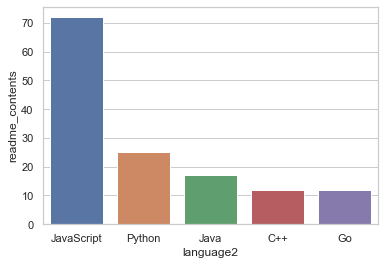

In [6]:
df3 = original.groupby('language').count().sort_values(by = 'repo',ascending=False).head()
df3['language2'] = df3.index
sns.set(style="whitegrid")
ax = sns.barplot(x="language2", y="readme_contents", data=df3)
print("Distribution of top 5 most common languages in dataset")

### Data Prep

Prepared data with cleaned data (lower case, only ascii, and no special characters), stemmed, and lemmatized

In [7]:
df = prep.prep_urls(original)

In [8]:
df.head(2)

,language,readme_contents,repo,original,clean,stemmed,lemmatized
0,JavaScript,![freeCodeCamp.org Social Banner](https://s3.a...,freeCodeCamp/freeCodeCamp,![freeCodeCamp.org Social Banner](https://s3.a...,freecodecamporg social bannerhttpss3amazonawsc...,freecodecamporg social bannerhttpss3amazonawsc...,freecodecamporg social bannerhttpss3amazonawsc...
1,Rust,[996.ICU](https://996.icu/#/en_US)\n=======\n*...,996icu/996.ICU,[996.ICU](https://996.icu/#/en_US)\n=======\n*...,996icuhttps996icuenus please note exists offic...,996icuhttps996icuenu pleas note exist offici a...,996icuhttps996icuenus please note exists offic...


- set the index to the repo name. 
- Only look at the top 5 most common languages
- Dropped readme_contents column

In [9]:
df.set_index('repo',inplace=True)
languages = ['JavaScript','Python','Java','C++','Go']
df = df[df.language.isin(languages)]
df.drop(columns='readme_contents')
df.head(2)

,language,readme_contents,original,clean,stemmed,lemmatized
repo,,,,,,
freeCodeCamp/freeCodeCamp,JavaScript,![freeCodeCamp.org Social Banner](https://s3.a...,![freeCodeCamp.org Social Banner](https://s3.a...,freecodecamporg social bannerhttpss3amazonawsc...,freecodecamporg social bannerhttpss3amazonawsc...,freecodecamporg social bannerhttpss3amazonawsc...
vuejs/vue,JavaScript,"<p align=""center""><a href=""https://vuejs.org"" ...","<p align=""center""><a href=""https://vuejs.org"" ...",p aligncentera hrefhttpsvuejsorg targetblank r...,p aligncentera hrefhttpsvuejsorg targetblank r...,p aligncentera hrefhttpsvuejsorg targetblank r...


In [10]:
df_nulls = df[df.language.isnull()]
df = df.dropna(axis=0)

In [11]:
df.shape

(138, 6)

In [12]:
corpus_complete = df.clean.sum() #corpus is one big string

In [13]:
javascript_corpus = df[df.language == "JavaScript"].clean.sum()

In [14]:
java_corpus = df[df.language == "Java"].clean.sum()

In [15]:
python_corpus = df[df.language == "Python"].clean.sum()

In [16]:
c_double_plus_corpus = df[df.language == "C++"].clean.sum()

In [17]:
go_corpus = df[df.language == "Go"].clean.sum()

In [18]:
total_corpus = df.clean.sum()
total_corpus

"freecodecamporg social bannerhttpss3amazonawscomfreecodecampwidesocialbannerpng pull requests welcomehttpsimgshieldsiobadgeprswelcomebrightgreensvgstyleflathttpmakeapullrequestcom firsttimersonly friendlyhttpsimgshieldsiobadgefirsttimersonlyfriendlybluesvghttpwwwfirsttimersonlycom open source helpershttpswwwcodetriagecomfreecodecampfreecodecampbadgesuserssvghttpswwwcodetriagecomfreecodecampfreecodecamp setup automatedhttpsimgshieldsiobadgesetupautomatedbluelogogitpodhttpsgitpodiofromreferrer freecodecamporg ' opensource codebase curriculum freecodecamporghttpswwwfreecodecamporg friendly community learn code free run donorsupported 501c3 nonprofithttpsdonatefreecodecamporg help millions busy adults transition tech community already helped 10000 people get first developer job fullstack web development curriculum completely free selfpaced thousands interactive coding challenges help expand skills table contents certificationscertifications learning platformthelearningplatform reporting b

### Exploration

#### Corpora for all combinations of text used (after cleaning)

Complete words in the corpus. Words included in the following language corpora: Javascript, Python, C++, Go and Java. Combined corpus for the 5 languages.

In [19]:
complete_words = corpus_complete.split()
javascript_words = javascript_corpus.split()
python_words = python_corpus.split()
c_double_plus_words = c_double_plus_corpus.split()
go_words = go_corpus.split()
java_words = java_corpus.split()
total_words = javascript_words + python_words + c_double_plus_words + go_words + java_words

In [20]:
df.head(2)

,language,readme_contents,original,clean,stemmed,lemmatized
repo,,,,,,
freeCodeCamp/freeCodeCamp,JavaScript,![freeCodeCamp.org Social Banner](https://s3.a...,![freeCodeCamp.org Social Banner](https://s3.a...,freecodecamporg social bannerhttpss3amazonawsc...,freecodecamporg social bannerhttpss3amazonawsc...,freecodecamporg social bannerhttpss3amazonawsc...
vuejs/vue,JavaScript,"<p align=""center""><a href=""https://vuejs.org"" ...","<p align=""center""><a href=""https://vuejs.org"" ...",p aligncentera hrefhttpsvuejsorg targetblank r...,p aligncentera hrefhttpsvuejsorg targetblank r...,p aligncentera hrefhttpsvuejsorg targetblank r...


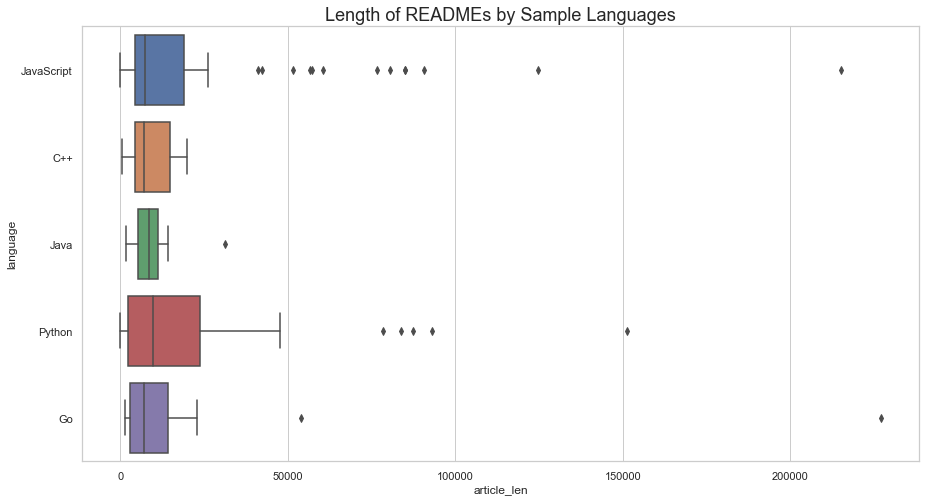

In [21]:
dfbox = df[['language','readme_contents']]
dfbox['article_len'] = dfbox.readme_contents.apply(len)
plt.figure(figsize=(15,8))
sns.boxplot(x=dfbox["article_len"], y = dfbox.language).set_title('Length of READMEs by Sample Languages', size = 18)
plt.show()

#### Wordclouds for each of the used corpora.

(-0.5, 399.5, 199.5, -0.5)

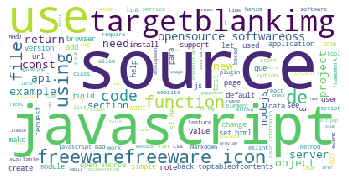

In [22]:
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords.words('english'), min_font_size = 10).generate(javascript_corpus)
img = WordCloud(background_color='white').generate(javascript_corpus)
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

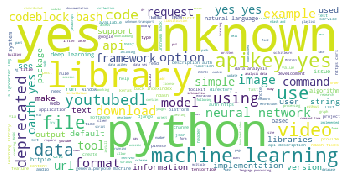

In [23]:
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords.words('english'), min_font_size = 10).generate(python_corpus)
img = WordCloud(background_color='white').generate(python_corpus)
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

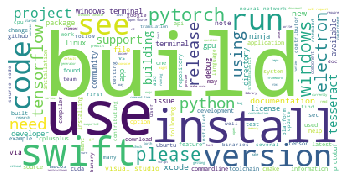

In [24]:
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords.words('english'), min_font_size = 10).generate(c_double_plus_corpus)
img = WordCloud(background_color='white').generate(c_double_plus_corpus)
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

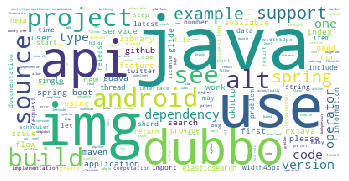

In [25]:
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords.words('english'), min_font_size = 10).generate(java_corpus)
img = WordCloud(background_color='white').generate(java_corpus)
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

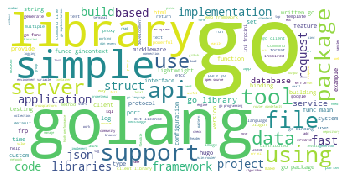

In [26]:
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords.words('english'), min_font_size = 10).generate(go_corpus)
img = WordCloud(background_color='white').generate(go_corpus)
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

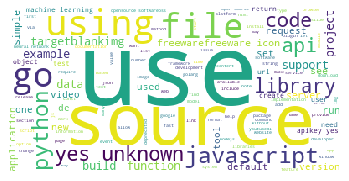

In [27]:
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords.words('english'), min_font_size = 10).generate(total_corpus)
img = WordCloud(background_color='white').generate(total_corpus)
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')

### Analysis of word frequency

In [28]:
corpus_complete_freq = pd.Series(complete_words).value_counts()
javascript_corpus_freq = pd.Series(javascript_words).value_counts()
python_freq = pd.Series(python_words).value_counts()
c_double_plus_freq = pd.Series(c_double_plus_words).value_counts()
java_freq = pd.Series(java_words).value_counts()
go_freq = pd.Series(go_words).value_counts()
total_freq = pd.Series(total_words).value_counts()

### Total for words present in Total Corpus

In [29]:
word_counts = (pd.concat([total_freq, javascript_corpus_freq, python_freq, java_freq, c_double_plus_freq, go_freq], axis=1, sort=True)
                .set_axis(['Total', 'JavaScript', 'Python', 'Java', 'C++', 'Go'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts = word_counts.sort_values(by = 'Total', ascending = False)
word_counts['word'] = word_counts.index
word_counts.head()

,Total,JavaScript,Python,Java,C++,Go,word
',3563,2541,654,174,69,125,'
&#9;,1920,671,3,53,0,1193,&#9;
go,1155,127,47,4,4,973,go
source,1069,880,70,38,28,53,source
javascript,1017,972,36,0,4,5,javascript


### Percent of total for words present in Total Corpus 

In [30]:
word_counts['perc'] = word_counts['Total']/len(word_counts)
word_counts.head()

,Total,JavaScript,Python,Java,C++,Go,word,perc
',3563,2541,654,174,69,125,',0.089552
&#9;,1920,671,3,53,0,1193,&#9;,0.048257
go,1155,127,47,4,4,973,go,0.029030
source,1069,880,70,38,28,53,source,0.026868
javascript,1017,972,36,0,4,5,javascript,0.025561


# Code and graphs for IDF to go here - I need help from Ryan to fix the code

### Beating the Baseline

#### Logistic Regression

Baseline model attempting to beat highest % language occurance (Javascript 52%). Uses Logistic regression to classify each programming language based on the content of the cleaned corpus words.

In [31]:
df = df[['clean','language']]
df.rename(columns={'clean':'body'},inplace=True)

In [32]:
df2 = df.copy()

In [33]:
tfidf = TfidfVectorizer()
X = tfidfs = tfidf.fit_transform(df.body)
y = df.language

In [34]:
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y,test_size=.2)

In [35]:
train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

lm = LogisticRegression().fit(X_train,y_train)

In [36]:
train['predicted_LR'] = lm.predict(X_train)
test['predicted_LR'] = lm.predict(X_test)

In [37]:
print("The train set predicted: ",round(sum(train.actual == train.predicted_LR)/len(train)*100),"%")
print("This was 4% better than the baseline of picking the most common language")

The train set predicted:  58 %
This was 4% better than the baseline of picking the most common language


In [38]:
print("The test set predicted: ",round(sum(test.actual == test.predicted_LR)/len(test)*100),"%")
print("This was 2% better than the baseline of picking the most common language")

The test set predicted:  54 %
This was 2% better than the baseline of picking the most common language


#### Random Forest Classifer

After this Logistic regression showed only a slight improvement on the test data a RF classifier was chosen to try to improve performance. Using a max depth of 3 we saw improvements on the train and test data. 

In [39]:
clf = RandomForestClassifier(max_depth = 4,random_state=123)
clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=4, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

In [40]:
train['predicted_RFC'] = clf.predict(X_train)
test['predicted_RFC'] = clf.predict(X_test)

In [41]:
print("The train set predicted: ",round(sum(train.actual == train.predicted_RFC)/len(train)*100),"%")
print("This was 8% better than the baseline of picking the most common language")

The train set predicted:  63 %
This was 8% better than the baseline of picking the most common language


In [42]:
print("The test set predicted: ",round(sum(test.actual == test.predicted_RFC)/len(test)*100),"%")
print("This was 5% better than the baseline of picking the most common language")

The test set predicted:  54 %
This was 5% better than the baseline of picking the most common language


In [43]:
#prediction of likelihood a corpus belongs to each language
preds = clf.predict_proba(X_train)
preds = pd.DataFrame(preds,columns=clf.classes_)
preds = preds.round(2)
train = train.reset_index()

In [44]:
train = pd.concat([train,preds],axis=1)

In [46]:
train.set_index('repo',inplace=True)
train.head(12)

,actual,predicted_LR,predicted_RFC,C++,Go,Java,JavaScript,Python
repo,,,,,,,,
ageitgey/face_recognition,Python,Python,JavaScript,0.06,0.07,0.08,0.45,0.33
facebook/jest,JavaScript,JavaScript,JavaScript,0.07,0.05,0.07,0.72,0.09
Dogfalo/materialize,JavaScript,JavaScript,JavaScript,0.08,0.08,0.10,0.59,0.15
zenorocha/clipboard.js,JavaScript,JavaScript,JavaScript,0.06,0.05,0.07,0.72,0.09
sahat/hackathon-starter,JavaScript,JavaScript,JavaScript,0.11,0.02,0.04,0.69,0.15
shadowsocks/shadowsocks,Python,JavaScript,JavaScript,0.09,0.10,0.12,0.51,0.17
psf/requests,Python,JavaScript,JavaScript,0.06,0.09,0.10,0.49,0.25
mrdoob/three.js,JavaScript,JavaScript,JavaScript,0.07,0.07,0.09,0.64,0.14
vuejs/vue,JavaScript,JavaScript,JavaScript,0.09,0.10,0.12,0.55,0.15


In [51]:
train.drop(columns='predicted_LR').sample(4)

,actual,predicted_RFC,C++,Go,Java,JavaScript,Python
repo,,,,,,,
facebook/react,JavaScript,JavaScript,0.05,0.05,0.07,0.70,0.12
atom/atom,JavaScript,JavaScript,0.17,0.10,0.09,0.50,0.14
TheAlgorithms/Python,Python,JavaScript,0.07,0.07,0.09,0.44,0.34
prometheus/prometheus,Go,JavaScript,0.09,0.19,0.15,0.44,0.12


In [50]:
df_idf = pd.read_csv('idf_csv.csv')
df_idf.shape

(36014, 10)

In [ ]:
idf_list = df_idf.word.to_list()

In [ ]:
idf_list = map(str,idf_list)

In [ ]:
idf_list = " ".join(idf_list)

In [ ]:
plt.figure(figsize=(15,8))
sns.distplot(df_idf.idf).set_title('IDFs 69 and Below', size = 18)
plt.ylabel('% of unique words in README data')
plt.show()

In [ ]:
df_idf = df_idf[df_idf.idf < 69]
df_idf.shape

In [ ]:
plt.figure(figsize=(15,8))
sns.distplot(df_idf.idf).set_title('IDFs Less than 69, non-inclusive', size = 18)
plt.ylabel('% of unique words in README data')
plt.show()

In [ ]:
def keep_word(word):
    return word in idf_list

def filter_documents(document):
    words = document.split()
    filtered_list = list(filter(keep_word,words))
    return " ".join(filtered_list)

In [ ]:
#df['body2'] = df.body.str.split()

In [ ]:
#df['body2'] = df.body.apply(filter_documents)

In [ ]:
df2['body'] = df.body.apply(filter_documents)

In [ ]:
tfidf = TfidfVectorizer()
X = tfidfs = tfidf.fit_transform(df2.body)
y = df2.language
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y,test_size=.2)

In [ ]:
clf = RandomForestClassifier(max_depth = 3,random_state=1)
clf.fit(X_train,y_train)

In [ ]:
train['predicted_RFC2'] = clf.predict(X_train)
test['predicted_RFC2'] = clf.predict(X_test)

In [ ]:
print("The train set predicted: ",round(sum(train.actual == train.predicted_RFC2)/len(train)*100),"%")
print("This was 3% worse than the baseline of picking the most common language")

In [ ]:
print("The test set predicted: ",round(sum(test.actual == test.predicted_RFC2)/len(test)*100),"%")
print("This was 2% better than the baseline of picking the most common language")

In [ ]:
bag_of_words = ['python','go','javascript','java','c++']

In [ ]:
string = "c++ is awesome$$$$$"

In [ ]:
'cplusplus' in idf_list